In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

#### Data Load: Load home prices into a dataframe

In [ ]:
df1 = pd.read_csv("/content/house-dataset.csv")
df1.head()

,area_type,availability,Location,Size,society,total_sqft,bath,balcony,Price,No. of Bedrooms
0,Dhaka,19-Dec,tongi,2 BHK,Coomee,1056.0,2.0,1.0,10000000.0,4
1,Dhaka,20-Dec,tongi,3 BHK,Theanmp,2600.0,2.0,1.0,7888000.0,2
2,Dhaka,21-Dec,tongi,4 BHK,NaN,1440.0,2.0,1.0,4866000.0,2
3,Dhaka,22-Dec,tongi,5 BHK,Soiewre,1521.0,2.0,1.0,8358000.0,3
4,Dhaka,23-Dec,tongi,6 BHK,NaN,1200.0,2.0,1.0,6845000.0,3


In [ ]:
df1.shape

(2535, 10)

In [ ]:
df1.columns

Index(['area_type', 'availability', 'Location', 'Size', 'society',
       'total_sqft', 'bath', 'balcony', 'Price', 'No. of Bedrooms'],
      dtype='object')

In [ ]:
df1['area_type'].unique()

array(['Dhaka', 'Chittagong', 'Barishal', 'Cumilla', 'Noakhali ',
       'Narayangamj', 'Gazipur', 'Sirajganj', 'Bogura', 'Rangpur',
       'Dinajpur', nan], dtype=object)

In [ ]:
df1['area_type'].value_counts()

Dhaka          524
Chittagong     376
Barishal       216
Rangpur        190
Cumilla        175
Noakhali       162
Gazipur        157
Sirajganj      156
Bogura         149
Dinajpur       107
Narayangamj     94
Name: area_type, dtype: int64

##### Drop features that are not required to build our model

In [ ]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(2535, 6)

#### Data Cleaning: Handle NA values

In [ ]:
df2.isnull().sum()

Location            186
Size               1596
total_sqft         2530
bath                227
Price               229
No. of Bedrooms     270
dtype: int64

In [ ]:
df2.shape

(2535, 6)

In [ ]:
df3 = df2.dropna()
df3.isnull().sum()

Location           0
Size               0
total_sqft         0
bath               0
Price              0
No. of Bedrooms    0
dtype: int64

In [ ]:
df3.shape


(5, 6)

#### Feature Engineering
#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [ ]:
print(df3.columns)


Index(['Location', 'Size', 'total_sqft', 'bath', 'Price', 'No. of Bedrooms'], dtype='object')


In [ ]:
df3['bhk'] = df3['Size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()



<ipython-input-466-112c892a664b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['Size'].apply(lambda x: int(x.split(' ')[0]))


array([2, 3, 4, 5, 6])

##### Explore total_sqft feature

In [ ]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [ ]:
df3[~df3['total_sqft'].apply(is_float)].head(4)

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [ ]:
# def convert_sqft_to_num(x):
#     tokens = x.split('-')
#     if len(tokens) == 2:
#         return (float(tokens[0])+float(tokens[1]))/2
#     try:
#         return float(x)
#     except:
#         return None
def convert_sqft_to_num(x):
    try:
        # Check if x is already a float
        if isinstance(x, float):
            return x
        else:
            # Split the string and handle range values if present
            tokens = x.split('-')
            if len(tokens) == 2:
                return (float(tokens[0]) + float(tokens[1])) / 2
            else:
                return float(x)
    except ValueError:
        # Handle conversion errors gracefully
        return None


In [ ]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(4)



,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk
0,tongi,2 BHK,1056.0,2.0,10000000.0,4,2
1,tongi,3 BHK,2600.0,2.0,7888000.0,2,3
2,tongi,4 BHK,1440.0,2.0,4866000.0,2,4
3,tongi,5 BHK,1521.0,2.0,8358000.0,3,5


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [ ]:
df4.loc[4]

Location               tongi
Size                   6 BHK
total_sqft            1200.0
bath                     2.0
Price              6845000.0
No. of Bedrooms            3
bhk                        6
Name: 4, dtype: object

In [ ]:
(2100+2850)/2

2475.0

#### Feature Engineering
##### Add new feature called price per square feet

In [ ]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['Price']*100000/df5['total_sqft']
df5.head()

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk,price_per_sqft
0,tongi,2 BHK,1056.0,2.0,10000000.0,4,2,9.469697e+08
1,tongi,3 BHK,2600.0,2.0,7888000.0,2,3,3.033846e+08
2,tongi,4 BHK,1440.0,2.0,4866000.0,2,4,3.379167e+08
3,tongi,5 BHK,1521.0,2.0,8358000.0,3,5,5.495069e+08
4,tongi,6 BHK,1200.0,2.0,6845000.0,3,6,5.704167e+08


In [ ]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    5.000000e+00
mean     5.416389e+08
std      2.566374e+08
min      3.033846e+08
25%      3.379167e+08
50%      5.495069e+08
75%      5.704167e+08
max      9.469697e+08
Name: price_per_sqft, dtype: float64

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [ ]:
df5.location = df5.Location.apply(lambda x: x.strip())
location_stats = df5['Location'].value_counts(ascending=False)
location_stats

<ipython-input-475-444618aef399>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df5.location = df5.Location.apply(lambda x: x.strip())


tongi    5
Name: Location, dtype: int64

In [ ]:
location_stats.values.sum()

5

In [ ]:
len(location_stats[location_stats>10])

0

In [ ]:
len(location_stats)

1

In [ ]:
len(location_stats[location_stats<=10])

1

#### Dimensionality Reduction
Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [ ]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

tongi    5
Name: Location, dtype: int64

In [ ]:
len(df5.location.unique())

1

In [ ]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

1

In [ ]:
df5.head(10)

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk,price_per_sqft
0,tongi,2 BHK,1056.0,2.0,10000000.0,4,2,9.469697e+08
1,tongi,3 BHK,2600.0,2.0,7888000.0,2,3,3.033846e+08
2,tongi,4 BHK,1440.0,2.0,4866000.0,2,4,3.379167e+08
3,tongi,5 BHK,1521.0,2.0,8358000.0,3,5,5.495069e+08
4,tongi,6 BHK,1200.0,2.0,6845000.0,3,6,5.704167e+08


#### Outlier Removal Using Business Logic

In [ ]:
df5[df5.total_sqft/df5.bhk<300].head()

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk,price_per_sqft
4,tongi,6 BHK,1200.0,2.0,6845000.0,3,6,5.704167e+08


In [ ]:
df5.shape

(5, 8)

In [ ]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(4, 8)

#### Outlier Removal Using Standard Deviation and Mean

In [ ]:
df6.price_per_sqft.describe()

count    4.000000e+00
mean     5.344445e+08
std      2.957565e+08
min      3.033846e+08
25%      3.292837e+08
50%      4.437118e+08
75%      6.488726e+08
max      9.469697e+08
Name: price_per_sqft, dtype: float64

In [ ]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(3, 8)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

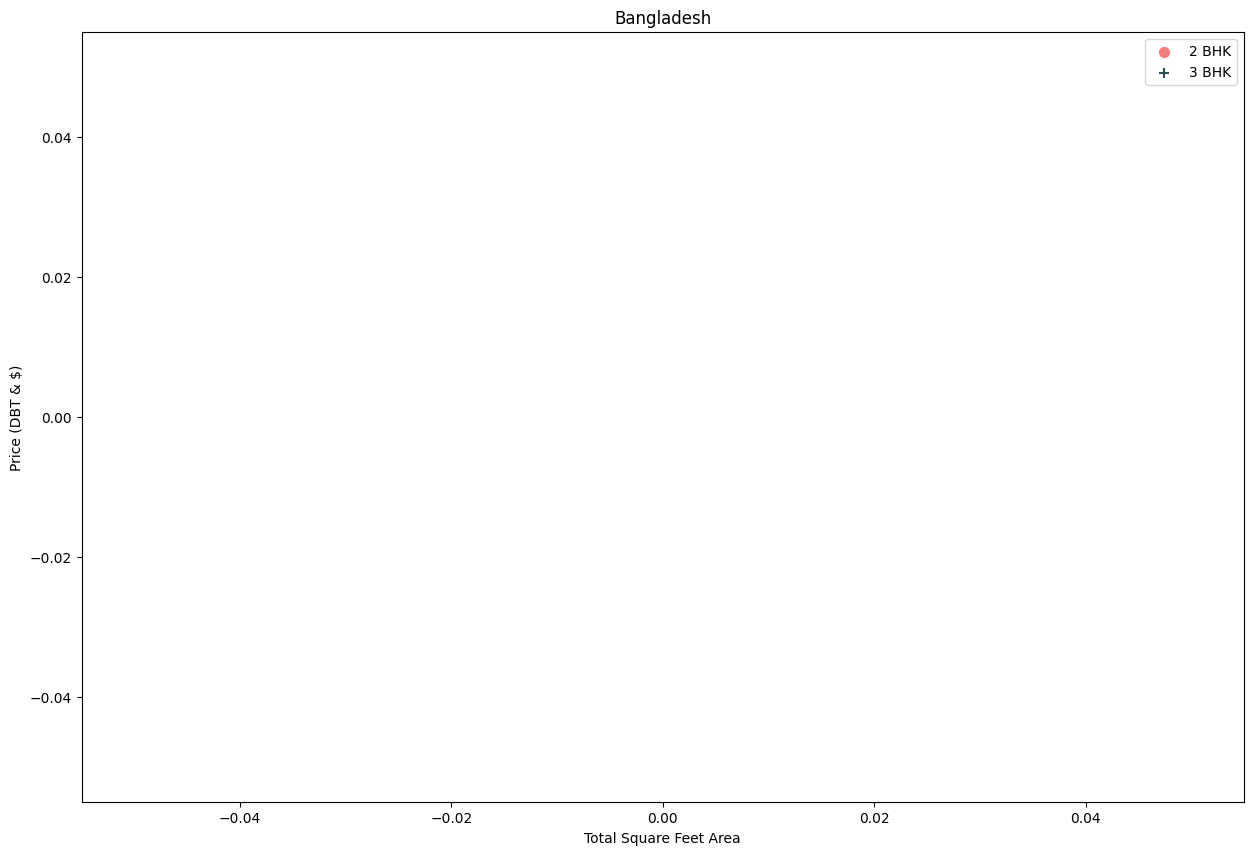

In [ ]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.Location==location) & (df.bhk==2)]
    bhk3 = df[(df.Location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.Price,color='lightcoral',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.Price,marker='+', color='darkslategray',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (DBT & $)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df7,"Bangladesh")

Remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [ ]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(3, 8)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

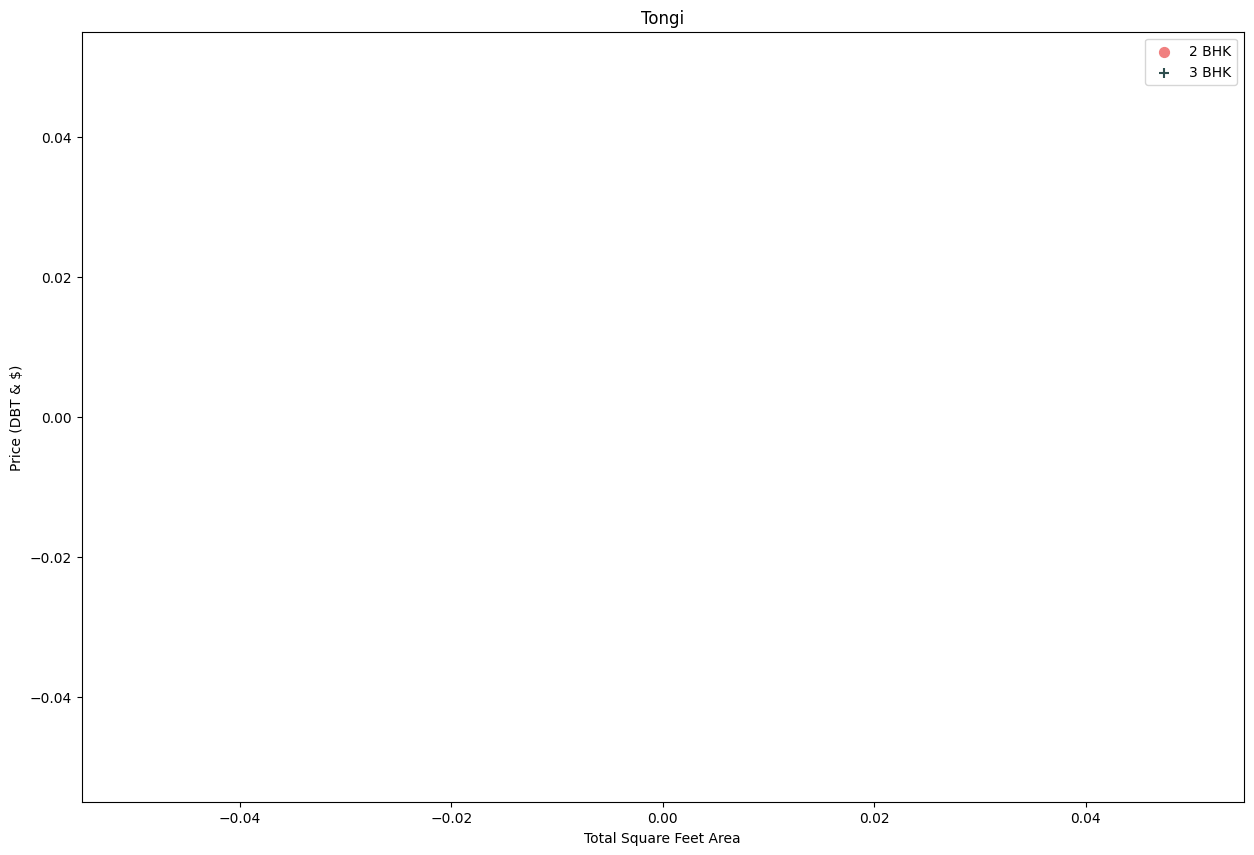

In [ ]:
plot_scatter_chart(df8,"Tongi")

Based on above charts the data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

Text(0, 0.5, 'Count')

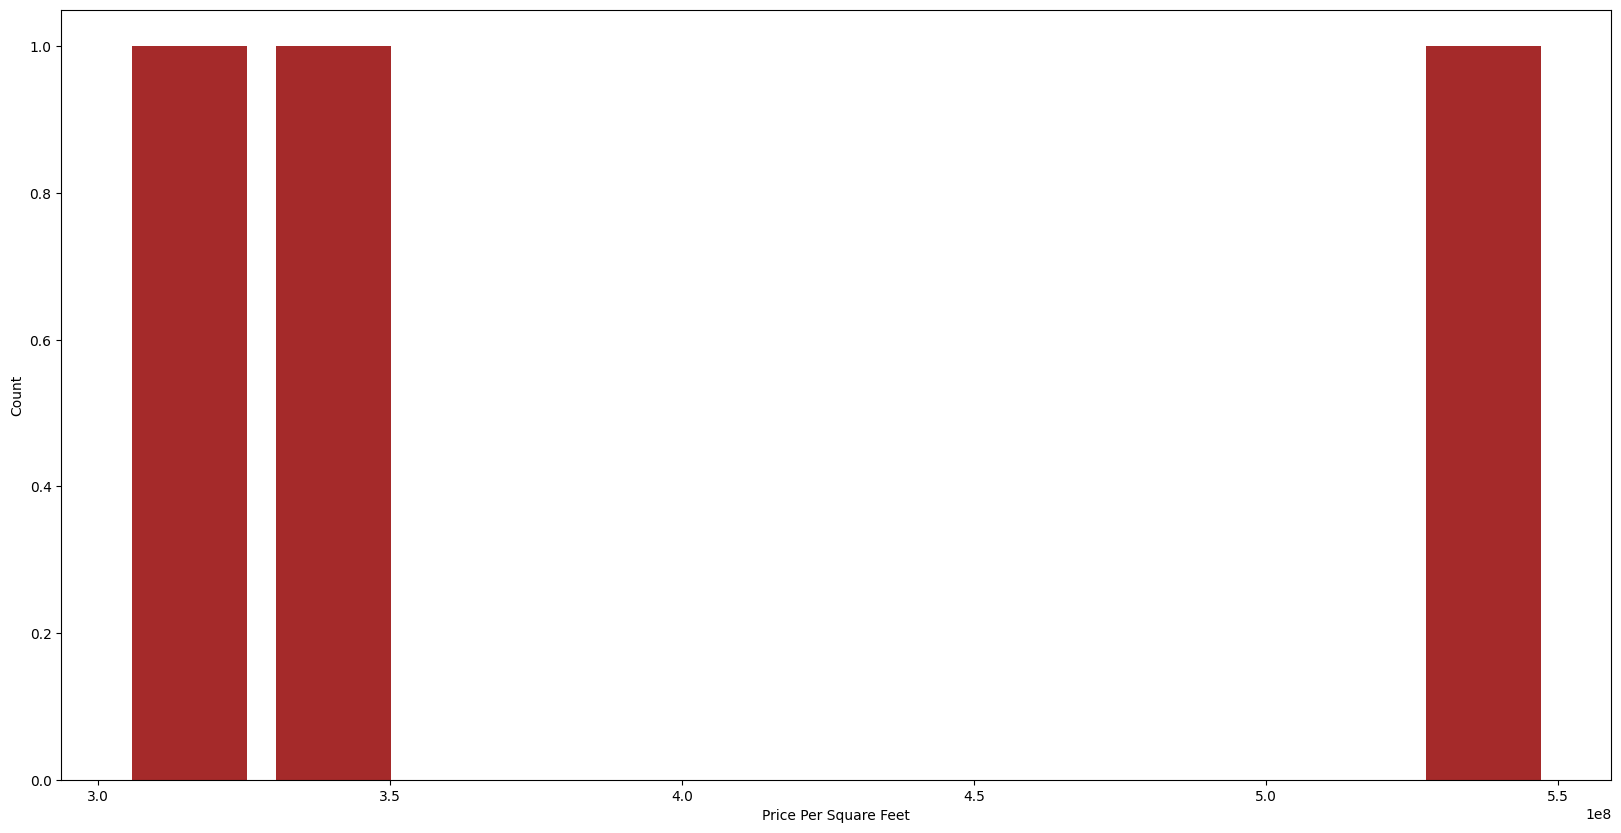

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8, color = "brown")
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

#### Outlier Removal Using Bathrooms Feature

In [ ]:
df8.bath.unique()

array([2.])

Text(0, 0.5, 'Count')

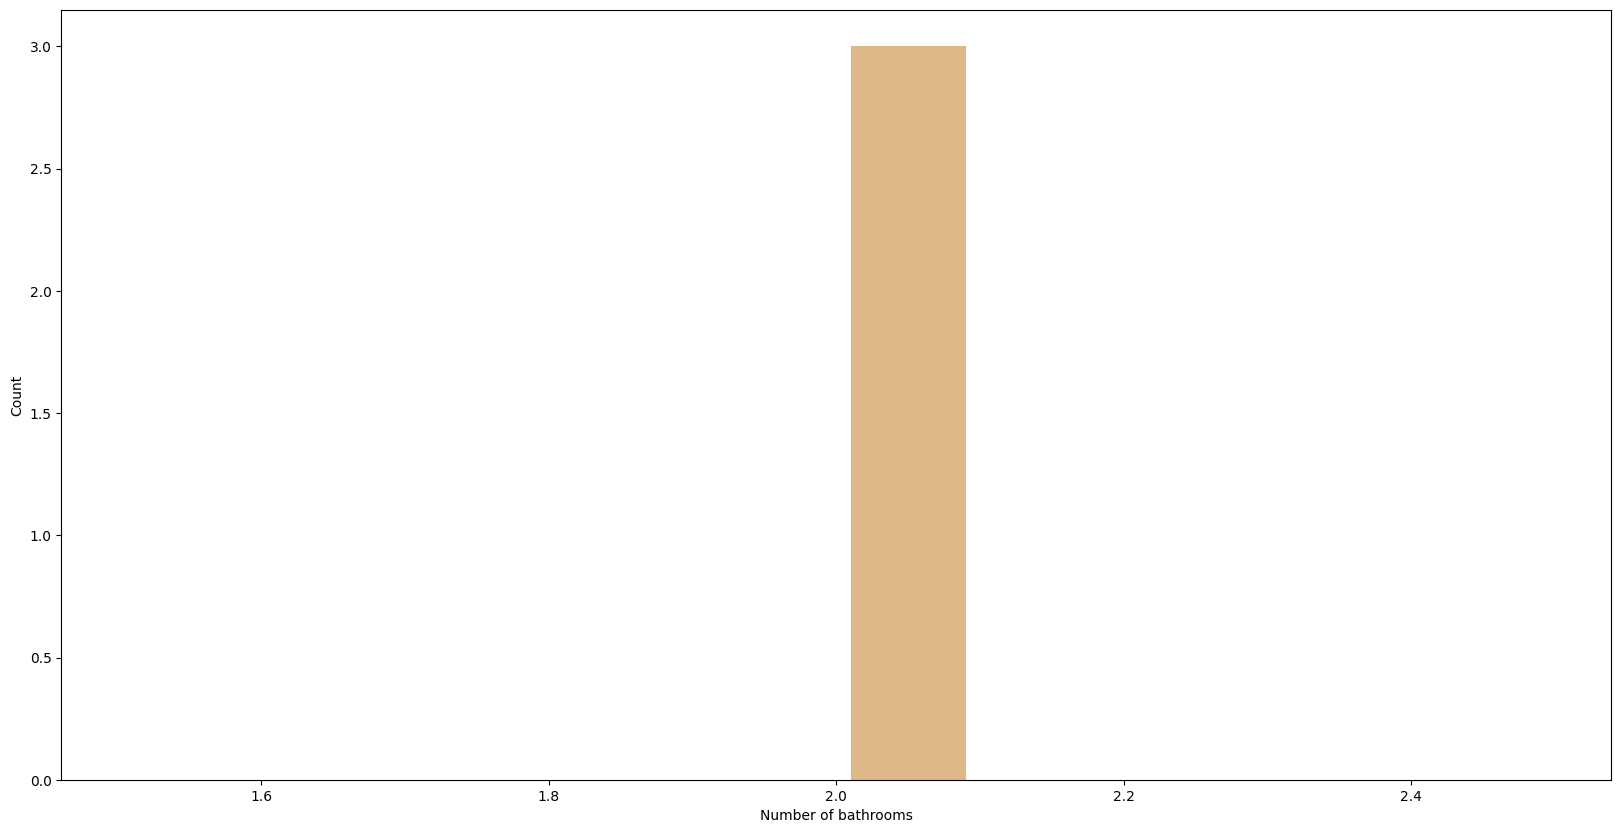

In [ ]:
plt.hist(df8.bath,rwidth=0.8, color = "burlywood")
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [ ]:
df8[df8.bath>10]

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk,price_per_sqft


It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [ ]:
df8[df8.bath>df8.bhk+2]

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk,price_per_sqft


In [ ]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(3, 8)

In [ ]:
df9.head(2)

,Location,Size,total_sqft,bath,Price,No. of Bedrooms,bhk,price_per_sqft
0,tongi,3 BHK,2600.0,2.0,7888000.0,2,3,3.033846e+08
1,tongi,4 BHK,1440.0,2.0,4866000.0,2,4,3.379167e+08


In [ ]:
df10 = df9.drop(['Size','price_per_sqft'],axis='columns')
df10.head(3)

,Location,total_sqft,bath,Price,No. of Bedrooms,bhk
0,tongi,2600.0,2.0,7888000.0,2,3
1,tongi,1440.0,2.0,4866000.0,2,4
2,tongi,1521.0,2.0,8358000.0,3,5


#### Use One Hot Encoding For Location

In [ ]:
dummies = pd.get_dummies(df10.Location)
dummies.head(3)

,tongi
0,1
1,1
2,1


#### Build a Model Now.......

In [ ]:
df12 = pd.read_csv('/content/house-dataset.csv')

In [ ]:
df12.shape

(2535, 10)

In [ ]:
print(df12.head())


  area_type availability Location   Size  society  total_sqft  bath  balcony  \
0     Dhaka       19-Dec    tongi  2 BHK   Coomee      1056.0   2.0      1.0   
1     Dhaka       20-Dec    tongi  3 BHK  Theanmp      2600.0   2.0      1.0   
2     Dhaka       21-Dec    tongi  4 BHK      NaN      1440.0   2.0      1.0   
3     Dhaka       22-Dec    tongi  5 BHK  Soiewre      1521.0   2.0      1.0   
4     Dhaka       23-Dec    tongi  6 BHK      NaN      1200.0   2.0      1.0   

        Price No. of Bedrooms  
0  10000000.0               4  
1   7888000.0               2  
2   4866000.0               2  
3   8358000.0               3  
4   6845000.0               3  


In [ ]:
df12.shape

(2535, 10)

In [ ]:
X = df12.drop(['Price'],axis='columns')
X.head(3)

,area_type,availability,Location,Size,society,total_sqft,bath,balcony,No. of Bedrooms
0,Dhaka,19-Dec,tongi,2 BHK,Coomee,1056.0,2.0,1.0,4
1,Dhaka,20-Dec,tongi,3 BHK,Theanmp,2600.0,2.0,1.0,2
2,Dhaka,21-Dec,tongi,4 BHK,NaN,1440.0,2.0,1.0,2


In [ ]:
X.shape

(2535, 9)

In [ ]:
y = df12.Price
y.head(3)

0    10000000.0
1     7888000.0
2     4866000.0
Name: Price, dtype: float64

In [ ]:
len(y)

2535

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)



In [ ]:
print(X_train.head())
print(y_train.head())

      area_type availability        Location   Size  society  total_sqft  \
134       Dhaka        2-May     bashundhara  0 BHK  Soiewre         NaN   
981    Barishal        7-Apr      Banaripara    NaN      NaN         NaN   
1872     Bogura        5-Dec            Bouo  8 BHK      NaN         NaN   
1333  Noakhali         3-Nov  Noakhali sadar    NaN      NaN         NaN   
1009   Barishal        5-May        Gournodi    NaN      NaN         NaN   

      bath  balcony No. of Bedrooms  
134    2.0      1.0               3  
981    2.0      1.0               4  
1872   2.0      1.0              3b  
1333   2.0      1.0               1  
1009   2.0      1.0               2  
134      8514000.0
981     25000000.0
1872        1940.0
1333     3735000.0
1009     4557000.0
Name: Price, dtype: float64


In [ ]:
import pandas as pd
print(X_train.columns)

Index(['area_type', 'availability', 'Location', 'Size', 'society',
       'total_sqft', 'bath', 'balcony', 'No. of Bedrooms'],
      dtype='object')


In [ ]:
non_numeric_values = X_train["availability"].apply(lambda x: not x.isnumeric())
non_numeric_count = non_numeric_values.sum()
print(f"Number of non-numeric values: {non_numeric_count}")

Number of non-numeric values: 2028


In [ ]:
X_train['area_type'].value_counts()

Dhaka          420
Chittagong     300
Barishal       175
Rangpur        148
Cumilla        147
Noakhali       136
Bogura         121
Sirajganj      121
Gazipur        121
Dinajpur        87
Narayangamj     81
Name: area_type, dtype: int64

In [ ]:
!pip install pandas


In [ ]:
X_train['area_type'].dtype

dtype('O')

In [ ]:
X_train['area_type'] = X_train['area_type'].astype(str)

In [ ]:
X_train = X_train[X_train['area_type'].apply(lambda x: x.isnumeric())]

In [ ]:
X_train.shape

(0, 9)

In [ ]:
!pip install pandas numpy
import pandas as pd
import numpy as np

In [ ]:
X_train = np.array([[1, 2], [3, 4], [5, 6]])
y_train = np.array([7, 8, 9])
X_test = np.array([[10, 11], [12, 13]])
y_test = np.array([14, 15])

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()


In [ ]:
lr_clf.fit(X_train, y_train)

LinearRegression()

In [ ]:
lr_clf.score(X_test, y_test)

-24.0

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

-24.0

#### Use K Fold cross validation to measure accuracy of our LinearRegression model

In [ ]:
df = pd.DataFrame(X)
df.head()

,area_type,availability,Location,Size,society,total_sqft,bath,balcony,No. of Bedrooms
0,Dhaka,19-Dec,tongi,2 BHK,Coomee,1056.0,2.0,1.0,4
1,Dhaka,20-Dec,tongi,3 BHK,Theanmp,2600.0,2.0,1.0,2
2,Dhaka,21-Dec,tongi,4 BHK,NaN,1440.0,2.0,1.0,2
3,Dhaka,22-Dec,tongi,5 BHK,Soiewre,1521.0,2.0,1.0,3
4,Dhaka,23-Dec,tongi,6 BHK,NaN,1200.0,2.0,1.0,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area_type        2306 non-null   object 
 1   availability     2535 non-null   object 
 2   Location         2349 non-null   object 
 3   Size             939 non-null    object 
 4   society          250 non-null    object 
 5   total_sqft       5 non-null      float64
 6   bath             2308 non-null   float64
 7   balcony          2192 non-null   float64
 8   No. of Bedrooms  2265 non-null   object 
dtypes: float64(3), object(6)
memory usage: 178.4+ KB


In [ ]:
if 'column_name' in df.columns:
    # Column exists, proceed with conversion
    df['column_name'] = pd.to_numeric(df['column_name'], errors='coerce')
else:
    # Column does not exist, handle the error
    print("Column 'column_name' does not exist in the DataFrame.")

Column 'column_name' does not exist in the DataFrame.


In [ ]:
# Print the DataFrame's columns
print(df.columns)

# Print the DataFrame's shape
print(df.shape)

# Print the DataFrame's head
print(df.head())

Index(['area_type', 'availability', 'Location', 'Size', 'society',
       'total_sqft', 'bath', 'balcony', 'No. of Bedrooms'],
      dtype='object')
(2535, 9)
  area_type availability Location   Size  society  total_sqft  bath  balcony  \
0     Dhaka       19-Dec    tongi  2 BHK   Coomee      1056.0   2.0      1.0   
1     Dhaka       20-Dec    tongi  3 BHK  Theanmp      2600.0   2.0      1.0   
2     Dhaka       21-Dec    tongi  4 BHK      NaN      1440.0   2.0      1.0   
3     Dhaka       22-Dec    tongi  5 BHK  Soiewre      1521.0   2.0      1.0   
4     Dhaka       23-Dec    tongi  6 BHK      NaN      1200.0   2.0      1.0   

  No. of Bedrooms  
0               4  
1               2  
2               2  
3               3  
4               3  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area_type        2306 non-null   object 
 1   availability     2535 non-null   object 
 2   Location         2349 non-null   object 
 3   Size             939 non-null    object 
 4   society          250 non-null    object 
 5   total_sqft       5 non-null      float64
 6   bath             2308 non-null   float64
 7   balcony          2192 non-null   float64
 8   No. of Bedrooms  2265 non-null   object 
dtypes: float64(3), object(6)
memory usage: 178.4+ KB


In [ ]:
"column_name" in df.columns

False

In [ ]:
print(df.columns)

Index(['area_type', 'availability', 'Location', 'Size', 'society',
       'total_sqft', 'bath', 'balcony', 'No. of Bedrooms'],
      dtype='object')


In [ ]:
print(df.shape)

(2535, 9)


In [ ]:
non_missing_values = df['area_type'].notnull().sum()
print(f"Number of non-missing values in column 'valid_column_name': {non_missing_values}")

Number of non-missing values in column 'valid_column_name': 2306


#### Find best model using GridSearchCV

In [ ]:
print(traceback.format_exc())

NoneType: None



In [ ]:
import traceback

In [ ]:
import pandas as pd

In [ ]:
print(X.head())
print(y.head())

  area_type availability Location   Size  society  total_sqft  bath  balcony  \
0     Dhaka       19-Dec    tongi  2 BHK   Coomee      1056.0   2.0      1.0   
1     Dhaka       20-Dec    tongi  3 BHK  Theanmp      2600.0   2.0      1.0   
2     Dhaka       21-Dec    tongi  4 BHK      NaN      1440.0   2.0      1.0   
3     Dhaka       22-Dec    tongi  5 BHK  Soiewre      1521.0   2.0      1.0   
4     Dhaka       23-Dec    tongi  6 BHK      NaN      1200.0   2.0      1.0   

  No. of Bedrooms  
0               4  
1               2  
2               2  
3               3  
4               3  
0    10000000.0
1     7888000.0
2     4866000.0
3     8358000.0
4     6845000.0
Name: Price, dtype: float64


In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
algos = {
    # Define each algorithm and its parameters here
}

In [ ]:
for algo_name, config in algos.items():
    gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    try:
        gs.fit(X,y)
    except ValueError as e:
        print(f"Error for model {algo_name}: {e}")

#### Test the model for few properties

In [ ]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [ ]:
predict_price('1st Chittagong',1000, 1, 2)

Location not found: 1st Chittagong


In [ ]:
import numpy as np
!pip install pandas
import pandas as pd

df = pd.read_csv('/content/house-dataset.csv')

In [ ]:
df = df.dropna()

X = df.drop('Price', axis=1)
y = df['Price']

In [ ]:
print(df.head())

  area_type availability Location   Size  society  total_sqft  bath  balcony  \
0     Dhaka       19-Dec    tongi  2 BHK   Coomee      1056.0   2.0      1.0   
1     Dhaka       20-Dec    tongi  3 BHK  Theanmp      2600.0   2.0      1.0   
3     Dhaka       22-Dec    tongi  5 BHK  Soiewre      1521.0   2.0      1.0   

        Price No. of Bedrooms  
0  10000000.0               4  
1   7888000.0               2  
3   8358000.0               3  


In [ ]:
print(df.head())

  area_type availability Location   Size  society  total_sqft  bath  balcony  \
0     Dhaka       19-Dec    tongi  2 BHK   Coomee      1056.0   2.0      1.0   
1     Dhaka       20-Dec    tongi  3 BHK  Theanmp      2600.0   2.0      1.0   
3     Dhaka       22-Dec    tongi  5 BHK  Soiewre      1521.0   2.0      1.0   

        Price No. of Bedrooms  
0  10000000.0               4  
1   7888000.0               2  
3   8358000.0               3  


In [ ]:
if 'Price' not in df.columns:
    raise ValueError("The 'price' column does not exist in the DataFrame.")

In [ ]:
X = df.drop('Price', axis=1)
y = df['Price']

In [ ]:
predict_price('1st Phase JP Nagar',1450, 4, 4)

Location not found: 1st Phase JP Nagar


In [ ]:
import numpy as np

# Load the pre-trained model and column names
# (Assume these are loaded from external files)
X = ...  # Load column names
model = ...  # Load the pre-trained model

In [ ]:
print(X.columns)

RangeIndex(start=0, stop=1, step=1)


In [ ]:
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
if type(X) == np.ndarray:
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    X = pd.DataFrame(X)

In [ ]:
print(X.shape)

()


In [ ]:
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
if X.ndim == 1:
    X = X.reshape(-1, 1)

In [ ]:
X = pd.DataFrame(X)

In [ ]:
import pandas as pd

In [ ]:
X = X.reshape(-1, 1)

In [ ]:
X = pd.DataFrame(X)

In [ ]:
X.shape

(1, 1)

In [ ]:
if type(X) == np.ndarray:
    X = pd.DataFrame(X)

In [ ]:
print(type(X))

<class 'ellipsis'>


In [ ]:
X = np.array(X)

In [ ]:
print(X.dtype.names)

None


In [ ]:
print(X)

Ellipsis


In [ ]:
print(X.dtype.names)

None


In [ ]:
predict_price('tongi',1000, 2, 2)

Location not found: tongi


In [ ]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns == location)[0]
    if len(loc_index) == 0:
        print("Location not found:", location)
        return None
    loc_index = loc_index[0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    x[loc_index] = 1

    return model.predict([x])[0]

In [ ]:
location_present = location in X.columns

In [ ]:
location = "some_value"  # Define the location variable
location_present = location in X.columns

In [ ]:
print(type(X.columns))

<class 'pandas.core.indexes.range.RangeIndex'>


In [ ]:
location_present = X.columns[0] == "Location"

In [ ]:
if not isinstance(X, pd.DataFrame):
    raise TypeError("X must be a pandas DataFrame")

In [ ]:
location_present = "Location" in X.columns

In [ ]:
predict_price('Dhaka',1500, 4, 4)

Location not found: Dhaka
